# Project: Application of neural network in denoising images
In this project, I use PyTorch to recreate images. To be more specific, I intend to denoise images using a neural network applied to noisy inputs. 


In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split, Dataset

# Dataset characteristics
The dataset used in this work may be found at (https://github.com/zalandoresearch/fashion-mnist).
A total of 60K images for training and 10K images for testing are available. Images are 28 x 28 pixels.

In my first three parts, I only use the first 5 classes from the dataset.

In [2]:
# Import first 5 classes from MNIST digit dataset
def importMnistDatasetFirstFiveClasses(train, transform=[]):
  # it will try to download the dataset if dataset is not found under the root directory 
  dataset = torchvision.datasets.FashionMNIST(root='./data', train=train, download=True, transform=transform) 
  idx = dataset.targets < 5
  dataset.targets = dataset.targets[idx]
  dataset.data = dataset.data[idx]

  return dataset

In [3]:
# Download datasets
train_set = importMnistDatasetFirstFiveClasses(train=True)
test_set = importMnistDatasetFirstFiveClasses(train=False)
print(train_set)
print(test_set)

100%|██████████| 26421880/26421880 [00:01<00:00, 15158688.48it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 315423.48it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5020515.03it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16842649.76it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 30000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: []
Dataset FashionMNIST
    Number of datapoints: 5000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: []


In [4]:
# View names of the first 5 classe
train_set.classes[:5]

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat']

# Visualization of dataset and noise function

In [5]:
# To add noise to images, we can take advantage of the transform module.
# We have defined custom transform class Noise to add noise during image transformation
class Noise(object):
    # Here we create a noisy version of the data set
    # The way that we do it is we go over all the pixels of
    # each of the data points; then with probability p we multiply
    # the value of that pixel by 0 (making it essentially black).
    # Otherwise (with probability 1-p) we multiply the value of that
    # pixel by 1 (essentially keeping the pixel untouched)

    # drop_probability is basically the probability of dropping a pixel (p in the above)
    # This is how we create the noisy data set.
    # Convert image_set to a numpy array
    def __init__(self, drop_probability=0):
        self.drop_probability = drop_probability
        
    def __call__(self, tensor):
        n = torch.from_numpy(np.random.choice([0, 1], size=tensor.size(), p=[self.drop_probability, 1-self.drop_probability])) 
        return tensor * n
    
    def __repr__(self):
        return self.__class__.__name__ + '(drop_probability={0})'.format(self.drop_probability)

# Return transform function to convert an image into a tensor.
# Add noise if drop_probability is provided.
def generateTransform(drop_probability):
  if drop_probability is not None and drop_probability > 0:
    trans_noise = transforms.Compose([
                              transforms.ToTensor(),
                              Noise(drop_probability)
                              ])
    return trans_noise
  else:
    return transforms.Compose([transforms.ToTensor()])

In [6]:
def show_gray_digits(image_set, row=2, col=3):
  # Here we visualize some of the data points in the data set. 
  # Create a large figure, to be filled with multiple subplots.

  # Since image_set is a tensor variable, we transform it to a numpy type variable.
  image_set = image_set.cpu().detach().numpy()

  for i in range(row*col):
    # define subplot
    plt.subplot(row, col, i+1)
    # plot raw pixel data
    plt.imshow(image_set[i,0], cmap=plt.get_cmap('gray'))
  # show the figure
  plt.show()

In the following we print some information about the data set. Then we will visualize some noisy digits.

In [7]:
# Load training dataset and add noise
train_set = importMnistDatasetFirstFiveClasses(train=True, transform=generateTransform(drop_probability=0.7))

# Add dataset to pytorch DataLoader with mini-batch size 64 s.t. each batch contains 64 images.
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)

# Get first batch of images and labels
train_image_batch, classe_set = next(iter(train_loader))

print(f'train_loader contains {len(train_loader)} batches of data.')
print(f'train_image_batch has shape {train_image_batch.shape},')
print('where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image),\
 28X28 stands for WxH (width and height of a single image).')

train_loader contains 469 batches of data.
train_image_batch has shape torch.Size([64, 1, 28, 28]),
where 64 is the number of images in a batch, 1 is the number of image channels (1 for grayscale image), 28X28 stands for WxH (width and height of a single image).


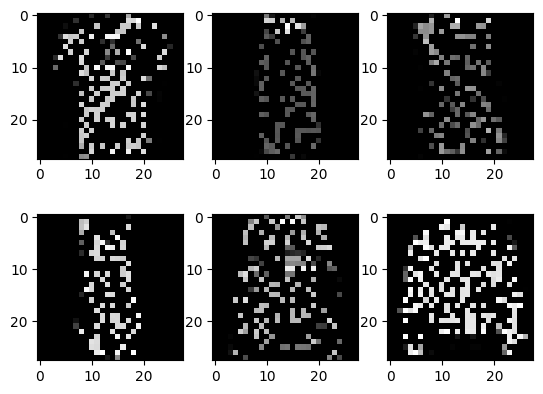

tensor([0, 0, 3, 0, 2, 2])


In [8]:
# display noised images and their corresponding labels.
show_gray_digits(train_image_batch, 2, 3)
print(classe_set[0:6])
del train_image_batch, classe_set, train_set, train_loader

# Create Dataloader
 The objective of tasks in the assignment is to train a network that, given a noisy image, recovers the original image. Therefore, each training point consists of the input (noisy image) and the expected output (true image). We will create pytorch dataloaders such that every element of the data loader is a pair of true image and noisy image. Also, we will use only a small portion of the training data to make the task more challenging.

In [9]:
# Function to create data loaders given the batch size
# Drop_probablity is used to control noise level
# importFunc accepts function as value
def load_data(batch_size, drop_probability=0.7, importFunc=importMnistDatasetFirstFiveClasses):  
  # Import MNIST train and test datasets.
  # Import train set without adding noise.
  train_set = importFunc(train=True, transform=generateTransform(0))

  # Use only the first 800 points for training
  train_set = torch.utils.data.Subset(train_set, list(range(1, 800)))

  # Import train set and add noise.
  train_set_noise = importFunc(train=True, transform=generateTransform(drop_probability))

  # Use only the first 800 points for training
  train_set_noise = torch.utils.data.Subset(train_set_noise, list(range(1, 800)))

  # Load the first 1000 points of test dataset
  test_set = importFunc(train=False, transform=generateTransform(0))
  test_set = torch.utils.data.Subset(test_set, list(range(1, 1000)))
  test_set_noise = importFunc(train=False, transform=generateTransform(drop_probability))
  test_set_noise = torch.utils.data.Subset(test_set_noise, list(range(1, 1000)))

  # Create a new dataset storing image pairs,
  # an item in the dataset is a pair of images (original and noised).
  train_set = PairDataset(train_set, train_set_noise)
  test_set = PairDataset(test_set, test_set_noise)

  # Generate train and test dataloaders,
  # Dataloader is used to loop through data batches.
  train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False)

  return train_loader, test_loader

# When get an item from the dataset, it returns a pair of data.
# In our case, it returns image and corresponding noised image.
class PairDataset(Dataset):
    def __init__(self, dataset_origin, dataset_noisy):
        self.dataset_origin = dataset_origin
        self.dataset_noisy = dataset_noisy

    def __getitem__(self, index):
        x1 = self.dataset_origin[index]
        x2 = self.dataset_noisy[index]
        return x1, x2

    def __len__(self):
        return len(self.dataset_origin)

Let us load all the data.


In [10]:
# Load train and test data.
train_loader, test_loader = load_data(batch_size=64)
print(f'train_loader has {len(train_loader)} batches')
print(f'test_loader has {len(test_loader)} batches')

train_loader has 13 batches
test_loader has 16 batches


In [11]:
# print(np.ceil(800/64)) #13
# print(np.ceil(5000/64)) #79

Let us visualize images in each dataloader.

train


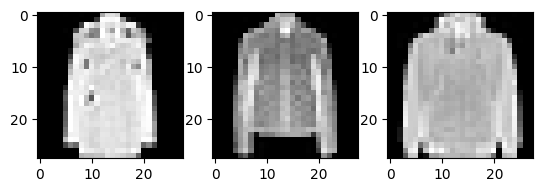

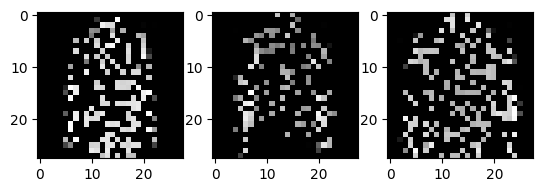

test


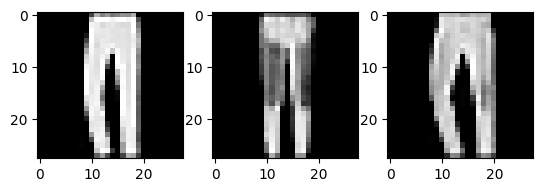

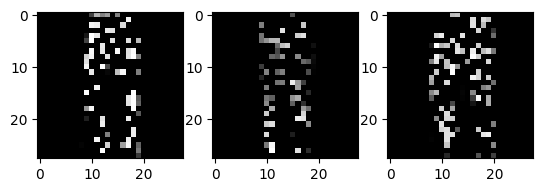

In [12]:
# Get a batch of images from each dataloader
train_image_batch, train_noise_image_batch = next(iter(train_loader))
test_image_batch, test_noise_image_batch = next(iter(test_loader))

# Show the first 3 image pairs
print('train')
show_gray_digits(train_image_batch[0], row=1, col=3)
show_gray_digits(train_noise_image_batch[0], 1, 3)
print('test')
show_gray_digits(test_image_batch[0], 1, 3)
show_gray_digits(test_noise_image_batch[0], 1, 3)
del train_loader, test_loader, train_image_batch, test_image_batch, train_noise_image_batch, test_noise_image_batch

# <font>Part1</font>-Image denoising using MLP

In this part, I reconstruct images by a **MLP** netwrok. The charactristics of the network is as follows:

*  two fully connected layers
*  the first layer looks like: nn.Linear(28*28, 1000)
*  the second layer looks like: nn.Linear(1000, 28*28)
*  I use an activation function as follows after each fully connected layer: nn.ReLU()






In [13]:
class MyNeuralNetRegressor(nn.Module):
  # Create a neural network with 1 hidden layers with 1000 neurons, 
  # and an output layer with 784 neurons (to match the dimension of our images!)
    def __init__(self):
        super(MyNeuralNetRegressor, self).__init__()

        # implement the two fully connected layers
        self.fc1 = nn.Linear(28*28, 1000) # implement the first fully connected layer
        self.fc2 = nn.Linear(1000, 28*28) # implement the second fully connected layer
        # implement relu
        self.relu = nn.ReLU() # implement the ReLU activation function
        
    def forward(self, x):
        x = x.view(-1, 28*28)            # 'flatten' the image to be of dimensions (#images, 784) instead of (#images, 1, 28, 28)

        x = self.relu(self.fc1(x))       # Implement the first fully connected layer and the ReLU activation function
        x = self.relu(self.fc2(x))       # Implement the second fully connected layer

        x = x.view(x.shape[0],1,28,28)   # 'unflatten' output data from dimensions (#images, 784) to (#images, 1, 28, 28)
        return x

# Use the free GPUs offered by Colab
if torch.cuda.is_available():
    device = torch.device('cuda') #GPU if available (cuda represents GPU)
else:
    device = torch.device('cpu')
  
# Verifying which device is being used GPU vs. CPU 
print(device)

cuda


 Train the network. I train a network to reconstruct images out of noisy inputs with the following requirments :
* epochs=50
* learning_rate=0.05
* optimizer = optim.Adam(NeuralNet.parameters(), lr=learning_rate)
* batch_size=64
* loss_function = nn.L1Loss()

For each epoch, sum up batch losses on train set as the train loss of the epoch. 

Finish the implementation of test function with the same loss function. For each epoch, also obtain test loss on test set.

The train function returns train and test loss of all epochs in a list.

In [14]:
def train(train_loader, test_loader, model, epochs, loss_function, optimizer):
  # Lists to store train and test loss of epoches
  train_loss_epochs = []
  test_loss_epochs = []

  # loop over the entire dataset #epochs times
  for epoch in range(epochs):  
    # print(f"epoch {epoch}")

    # List to store train loss of batches
    train_loss_batches = []

    for train_image_batch, train_noise_image_batch in iter(train_loader):
      # set model to training mode
      model.train()
      train_image_batch = train_image_batch[0].to(device)
      train_noise_image_batch = train_noise_image_batch[0].to(device)

      optimizer.zero_grad()
      pred = model(train_noise_image_batch)
      loss = loss_function(pred, train_image_batch)
      loss.backward()
      optimizer.step()
      train_loss_batches.append(loss.item())
   
    # obtain average batch test loss
    test_loss_batch = test(test_loader, model, loss_function)

    train_loss_epochs.append(np.mean(train_loss_batches))
    test_loss_epochs.append(test_loss_batch)

  return train_loss_epochs, test_loss_epochs

# This is our test function. We pass all the testing data
# through the Network and compute the loss.
# Returns average batch test loss.
def test(dataloader, model, loss_function):
  # List to store test loss of batches.
  test_loss_batches = []

  model.to(device)

  # Set model to eval mode.
  model.eval()

  with torch.no_grad():
    for image_batch, noise_image_batch in iter(dataloader):
        image_batch = image_batch[0].to(device)
        noise_image_batch = noise_image_batch[0].to(device)
        pred = model(noise_image_batch)
        loss = loss_function(pred, image_batch)
        test_loss_batches.append(loss.item())
  return np.mean(test_loss_batches)

Load train and test data by calling load_data function with drop_probability=0.7. Train MyNeuralNetRegressor to denoise images. Report the train and test loss of the last epoch.

In [15]:
# Create a fresh model named model_task1
model_task1 = MyNeuralNetRegressor()
model_task1.to(device)

# Define L1 loss function
loss_function = nn.L1Loss()

# Load train and test data
train_loader, test_loader = load_data(batch_size=64)

# Define optimizer for learning weights(parameters). 
# Adam and SGD are two commonly used optimizers.
# We use Adam here.
optimizer = optim.Adam(model_task1.parameters(), lr=0.05)

# Train the model
train_loss_epochs, test_loss_epochs = train(train_loader, test_loader, model_task1, epochs=50, loss_function=loss_function, optimizer=optimizer)

print(f'The train loss of the last epoch is {train_loss_epochs[-1]}')
print(f'The test loss of the last epoch is {test_loss_epochs[-1]}')


The train loss of the last epoch is 0.13611943102799928
The test loss of the last epoch is 0.13746831472963095


**Training plots**

Draw a graph that shows the train loss and test loss throughout the traning. I use plot function from matplotlib library. X-axis is the epochs number Y-axis corresponds loss. Draw two graphs for train loss and test loss on the same plot.

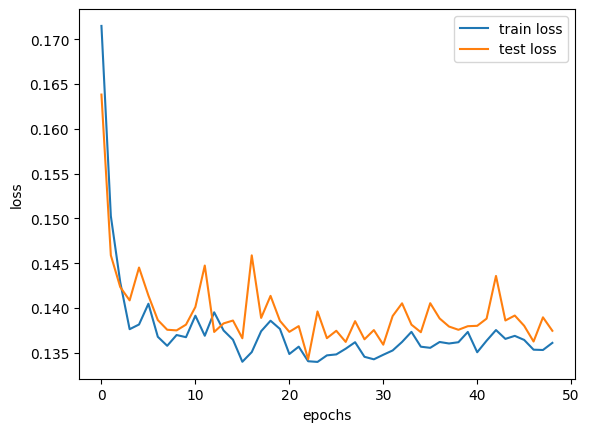

In [16]:
def plot_eval_results(train_loss_epochs, test_loss_epochs):
  # your code
    plt.plot(train_loss_epochs, label='train loss')
    plt.plot(test_loss_epochs, label='test loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

# You may ignore the loss of the first epoch for better visualization 
plot_eval_results(train_loss_epochs[1:], test_loss_epochs[1:])

# <font>Part2 </font>-  Image denoising using CNN


Convolutional Neural Network(CNN) have been quite successful in the field of image processing. Let us implement a basic CNN. We can replace fully connected layers in MyNeuralNetRegressor with convolutional layers.
A convolutional layer can be implemented in pytorch like

```
nn.Conv2d(in_channels=, out_channels=, kernel_size=, padding=, stride=)
```



**A** Same as the former section, in this part I denoise images but using a **CNN**. The charactristics of the network is as follows:

*  two conv layers
*  the first layer looks like: *nn.Conv2d(in_channels=1, out_channels=10,kernel_size=3, padding=1, stride=1)*
*  the second layer looks like: *nn.Conv2d(in_channels=10, out_channels=1,kernel_size=3, padding=1, stride=1)*
*  we use an activation function as follows after each conv layer: nn.ReLU()

In [17]:
class MyCNN(nn.Module):
  # We create a 2 layers CNN. 
  # First conv is configured with filters(kernels) size 3, padding 1, and stride 1.
  # The first conv's inputs are images in dimension 28*28*1 (W*H*1). 
  # Its output is in dimension 28*28*10 (W1*H1*num_feature_maps), where
      # W1=(W-Filter+2*Padding)/Stride+1 => 28=(28-3+2)/1+1.
      # H1=(H-Filter+2*Padding)/Stride+1 => 28=(28-3+2)/1+1.
  # Apply ReLU to the first conv output.
  # Pass the result as input to the second conv layer.
  # The second conv is configured with padding 1 and stride 1. 
  # It outputs denoised images (dimension 28*28*1).
      
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10,kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=1,kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        return x

**B** Train the network.
To reconstruct pictures from noisy inputs, we will train a CNN network with the following requirements: 
* epochs=50
* learning_rate=0.05
* optimizer = optim.Adam(NeuralNet.parameters(), lr=learning_rate)
* batch_size=64
*loss_function = nn.L1Loss()

For each epoch, sum up batch losses on train set as the train loss of the epoch. 

For each epoch, also obtain test loss on test set.

The train function returns train and test loss of all epochs in a list.

In [18]:
# name the CNN model model_task2
model_task2 = MyCNN()
model_task2.to(device)

# Define L1 loss function
loss_function = nn.L1Loss()

# Load train and test data
train_loader, test_loader = load_data(batch_size=64)

# Define optimizer for learning weights(parameters). 
# Adam and SGD are two commonly used optimizers.
# We use Adam here.
optimizer = optim.Adam(model_task2.parameters(), lr=0.05)




Load train and test data by calling load_data function with drop_probability=0.7. Train MyCNN to denoise images. Report the train and test loss of the last epoch.

In [19]:
# Train the model
train_loss_epochs, test_loss_epochs = train(train_loader, test_loader, model_task2, epochs=50, loss_function=loss_function, optimizer=optimizer)

print(f'The train loss of the last epoch is {train_loss_epochs[-1]}')
print(f'The test loss of the last epoch is {test_loss_epochs[-1]}')

The train loss of the last epoch is 0.10019882539143929
The test loss of the last epoch is 0.10191707964986563


**Training plots**

**C** I draw a graph that shows the train loss and test loss throughout the traning. I use plot function from matplotlib library. X-axis is the epochs numberY-axis corresponds loss.raw two graphs for train loss and test loss on the same plot.

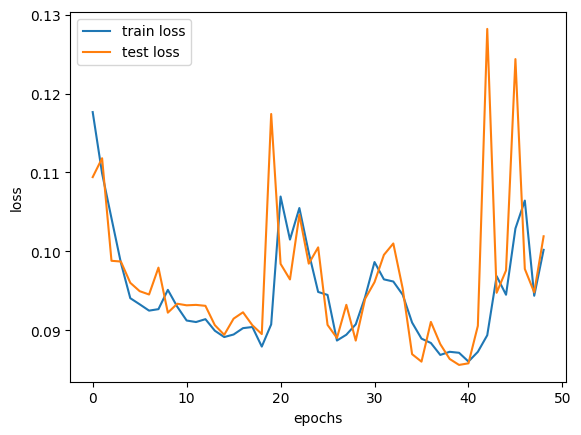

In [20]:
plot_eval_results(train_loss_epochs[1:], test_loss_epochs[1:])

# <font>Part3 </font>-Image denoising with vertical noise
To visualize the denoising results, I denoise first ten photos from test set with the NeuralNetworkRegressor (MLP) and CNN respectively, and display the denoised images along with original images.


Original images:


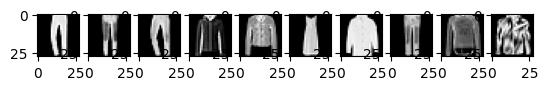

Noisy images:


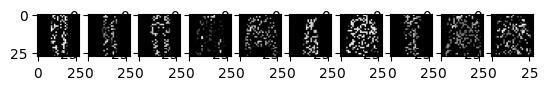

MLP denoised images:


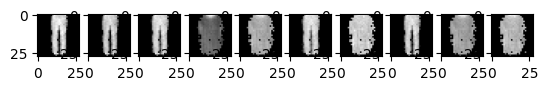

CNN denoised images:


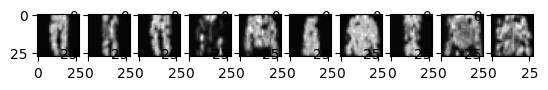

In [21]:
image_batch, noise_image_batch = next(iter(test_loader))
image_batch = image_batch[0]
noise_image_batch = noise_image_batch[0]

print('Original images:')
show_gray_digits(image_batch, 1, 10)
print('Noisy images:')
show_gray_digits(noise_image_batch, 1, 10)
print('MLP denoised images:')
mlp_output = model_task1(noise_image_batch[0:10].to(device))
show_gray_digits(mlp_output, 1, 10)
print('CNN denoised images:')
cnn_output = model_task2(noise_image_batch[0:10].to(device))
show_gray_digits(cnn_output, 1, 10)
plt.show()

**Image reconstruction-vertical and horizontal noises**

I want to examine the effectiveness of the neural networks that I trained in the previous parts (MLP and CNN) to denoise some images that are noised with a new type of noise (i.e., vertical noise). The noise function is defined as follows:


In [22]:
def add_line_noise(batch_image):
  for i in range(len(batch_image)):
      batch_image[i,0,18:20,:] = 0
      batch_image[i,0,22:26,:] = 0
      batch_image[i,0,:,18:20] = 0
      batch_image[i,0,:,22:26] = 0
  return batch_image

Using the above function, create the noisy version of the first 10 images in the test set. Denoise these images with the trained MLP and CNN respectively Display the denoised images and original images.

Original images:


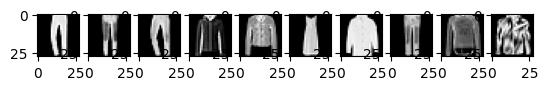

Noisy images:


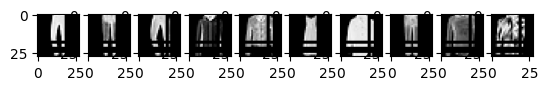

MLP denoised images:


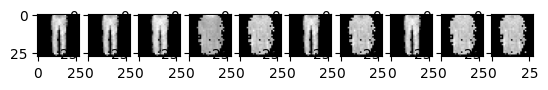

CNN denoised images:


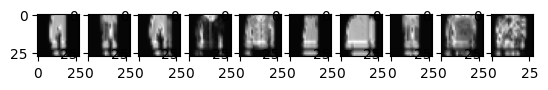

In [23]:
image_batch, noise_image_batch = next(iter(test_loader))
image_batch = image_batch[0]

print('Original images:')
show_gray_digits(image_batch, 1, 10)

noise_image_batch = add_line_noise(image_batch)
print('Noisy images:')
show_gray_digits(noise_image_batch, 1, 10)
print('MLP denoised images:')
mlp_output = model_task1(noise_image_batch[0:10].to(device))
show_gray_digits(mlp_output, 1, 10)
print('CNN denoised images:')
cnn_output = model_task2(noise_image_batch[0:10].to(device))
show_gray_digits(cnn_output, 1, 10)
plt.show()

# <font>Part 4 </font>-Image denoising on other classes 
In the first 3 parts, I trained MLP and CNN models on the first 5 classes of the data set (out of 10 classes). In this part,I use the trained models from previous tasks and run them on the last 5 classes.


In [24]:
# Import the last 5 classes from MNIST digit dataset
def importMnistDatasetLastFiveClasses(train, transform=[]):
  # it will try to download the dataset if dataset is not found under the root directory 
  dataset = torchvision.datasets.FashionMNIST(root='./data', train=train, download=True, transform=transform) 
  idx = dataset.targets > 5
  dataset.targets = dataset.targets[idx]
  dataset.data = dataset.data[idx]

  return dataset

In [25]:
# Load test data.
_, test_loader = load_data(batch_size=64, importFunc=importMnistDatasetLastFiveClasses)
print(f'test_loader has {len(test_loader)} batches')

test_loader has 16 batches


Report loss of the trained MLP and CNN models on the test set of the last 5 classes.


In [26]:
mlp_output=test(test_loader, model_task1, loss_function)
print(f'The train loss of the trained MLP model is {mlp_output}')

cnn_output=test(test_loader, model_task2, loss_function)
print(f'The test loss of the trained CNN model is {cnn_output}')

The train loss of the trained MLP model is 0.227785830385983
The test loss of the trained CNN model is 0.10165623761713505
